<a href="https://colab.research.google.com/github/cu7th0n/ssq/blob/master/ssq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
from bs4 import BeautifulSoup
import xlwt
import time

#获取第一页的内容
def get_one_page(url):
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
    }
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        return response.text
    return 

#解析第一页内容，数据结构化
def parse_one_page(html):

    soup = BeautifulSoup(html,'lxml')
    i = 0
    for item in soup.select('tr')[2:-1]:

        yield{
            'time':item.select('td')[i].text,
            'digit_1':item.select('td em')[0].text,
            'digit_2':item.select('td em')[1].text,
            'digit_3':item.select('td em')[2].text,
            'digit_4':item.select('td em')[3].text,
            'digit_5':item.select('td em')[4].text,
            'digit_6':item.select('td em')[5].text,
            'digit_7':item.select('td em')[6].text,
        }

#将数据写入Excel表格中
def write_to_excel():
    f = xlwt.Workbook()                             
    sheet1 = f.add_sheet('ssq',cell_overwrite_ok=True)
    row0 = ["date","digit_1","digit_2","digit_3","digit_4","digit_5","digit_6","digit_7"]
    #写入第一行
    for j in range(0,len(row0)):
        sheet1.write(0,j,row0[j])

    #依次爬取每一页内容的每一期信息，并将其依次写入Excel
    i=0
    for k in range(1,122):
        url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_%s.html' %(str(k))
        html = get_one_page(url)
        
        #写入每一期的信息
        for item in parse_one_page(html):
            sheet1.write(i+1,0,item['time'])
            sheet1.write(i+1,1,item['digit_1'])
            sheet1.write(i+1,2,item['digit_2'])
            sheet1.write(i+1,3,item['digit_3'])
            sheet1.write(i+1,4,item['digit_4'])
            sheet1.write(i+1,5,item['digit_5'])
            sheet1.write(i+1,6,item['digit_6'])
            sheet1.write(i+1,7,item['digit_7'])
            i+=1
    
    f.save('ssq.xls')
    print('%d页已保存。'%k)
    
def main():
    write_to_excel()

if __name__ == '__main__':
    main()

121页已保存。


In [0]:
import pandas as pd
data = pd.read_excel('ssq.xls')
data.head()



,date,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6,digit_7
0,2019-05-05,8,9,10,13,15,28,9
1,2019-05-02,4,6,10,11,21,23,2
2,2019-04-30,3,10,13,22,23,28,15
3,2019-04-28,3,7,10,12,18,29,10
4,2019-04-25,3,11,18,25,30,33,14


In [0]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by = 'date')
data.reset_index(inplace=True)
del data['index']
del data['date']

In [0]:
data.head()

,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6,digit_7
0,10,11,12,13,26,28,11
1,4,9,19,20,21,26,12
2,1,7,10,23,28,32,16
3,4,6,7,10,13,25,3
4,4,6,15,17,30,31,16


In [0]:
D_1 = data['digit_1']
D_2 = data['digit_2']
D_3 = data['digit_3']
D_4 = data['digit_4']
D_5 = data['digit_5']
D_6 = data['digit_6']
D_7 = data['digit_7']

In [0]:
import numpy as np

def create_interval_dataset(dataset, look_back):
    """
    :param dataset: input array of time intervals
    :param look_back: each training set feature length
    :return: convert an array of values into a dataset matrix.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:i+look_back-1])
        dataY.append(dataset[i+look_back])
    return np.asarray(dataX), np.asarray(dataY)


In [0]:
def train_model(train_set,model_name,look_back = 300,data_dim = 34,batch_size = 1):
  from keras.utils import to_categorical
  from keras.models import Sequential
  from keras.layers import LSTM, Dense, Dropout
  from keras.callbacks import EarlyStopping
  import numpy as np
  import matplotlib.pyplot as plt

  timesteps = look_back-1
 
  model = Sequential()
  model.add(LSTM(data_dim, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*2, return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))

  model.add(LSTM(data_dim*4,  stateful=True))
  model.add(Dropout(0.3))
  
  model.add(Dense(data_dim, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

  df = to_categorical(train_set,data_dim)
  
  dataX, dataY = create_interval_dataset(df, look_back) 
  
  total = len(train_set)
  split = total*8//10

  X_train = dataX[:split]
  y_train = dataY[:split]

  X_val = dataX[split+1:total-1]
  y_val = dataY[split+1:total-1]
  
  filepath='weights.best.'+  model_name[:2] + '.hdf5'
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  history = model.fit(X_train, y_train,batch_size=batch_size, epochs=10,
            shuffle=False,validation_data=(X_val, y_val),callbacks=[early_stop])
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  model.save_weights(filepath)
  model.load_weights(filepath)
  model.save(model_name)


In [0]:
models = ['M1_model.h5', 'M2_model.h5', 'M3_model.h5',
          'M4_model.h5', 'M5_model.h5','M6_model.h5','M7_model.h5']
tdatas = [D_1, D_2, D_3, D_4, D_5, D_6, D_7]

look_back=5
for (model,tdata) in zip(models,tdatas):
  train_model(tdata,model,look_back)

In [0]:
import requests
from bs4 import BeautifulSoup
import xlwt
import time

#获取第一页的内容
def get_one_page(url):
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
    }
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        return response.text
    return 

#解析第一页内容，数据结构化
def parse_one_page(html):

    soup = BeautifulSoup(html,'lxml')
    i = 0
    for item in soup.select('tr')[2:-1]:

        yield{
            'time':item.select('td')[i].text,
            'digit_1':item.select('td em')[0].text,
            'digit_2':item.select('td em')[1].text,
            'digit_3':item.select('td em')[2].text,
            'digit_4':item.select('td em')[3].text,
            'digit_5':item.select('td em')[4].text,
            'digit_6':item.select('td em')[5].text,
            'digit_7':item.select('td em')[6].text,
        }

#将数据写入Excel表格中
def create_test_excel(lookback):
    f = xlwt.Workbook()                             
    sheet1 = f.add_sheet('ssq',cell_overwrite_ok=True)
    row0 = ["date","digit_1","digit_2","digit_3","digit_4","digit_5","digit_6","digit_7"]
    #写入第一行
    for j in range(0,len(row0)):
        sheet1.write(0,j,row0[j])

    #依次爬取每一页内容的每一期信息，并将其依次写入Excel
    i=0
    for k in range(1,122):
        if i == lookback + 1:
          break
        url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_%s.html' %(str(k))
        html = get_one_page(url)
        
        #写入每一期的信息
        for item in parse_one_page(html):
            sheet1.write(i+1,0,item['time'])
            sheet1.write(i+1,1,item['digit_1'])
            sheet1.write(i+1,2,item['digit_2'])
            sheet1.write(i+1,3,item['digit_3'])
            sheet1.write(i+1,4,item['digit_4'])
            sheet1.write(i+1,5,item['digit_5'])
            sheet1.write(i+1,6,item['digit_6'])
            sheet1.write(i+1,7,item['digit_7'])
            i+=1
    
    f.save('ssq_test.xls')
    print('%d页已保存。'%k)


M1_model.h5


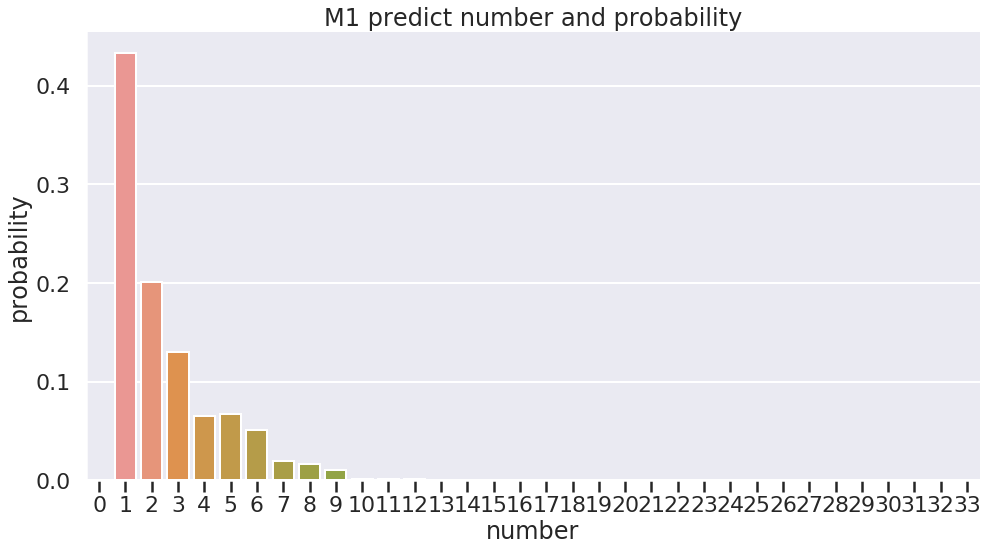

1 : 43.31%
2 : 20.11%
3 : 13.05%
5 : 6.75%
4 : 6.53%
6 : 5.11%
7 : 1.98%
8 : 1.66%
9 : 1.05%
10 : 0.17%
11 : 0.11%
12 : 0.10%
13 : 0.03%
14 : 0.02%
16 : 0.01%
15 : 0.01%
17 : 0.00%
19 : 0.00%
20 : 0.00%
18 : 0.00%
24 : 0.00%
22 : 0.00%
23 : 0.00%
33 : 0.00%
25 : 0.00%
31 : 0.00%
0 : 0.00%
21 : 0.00%
29 : 0.00%
32 : 0.00%
26 : 0.00%
27 : 0.00%
30 : 0.00%


M2_model.h5


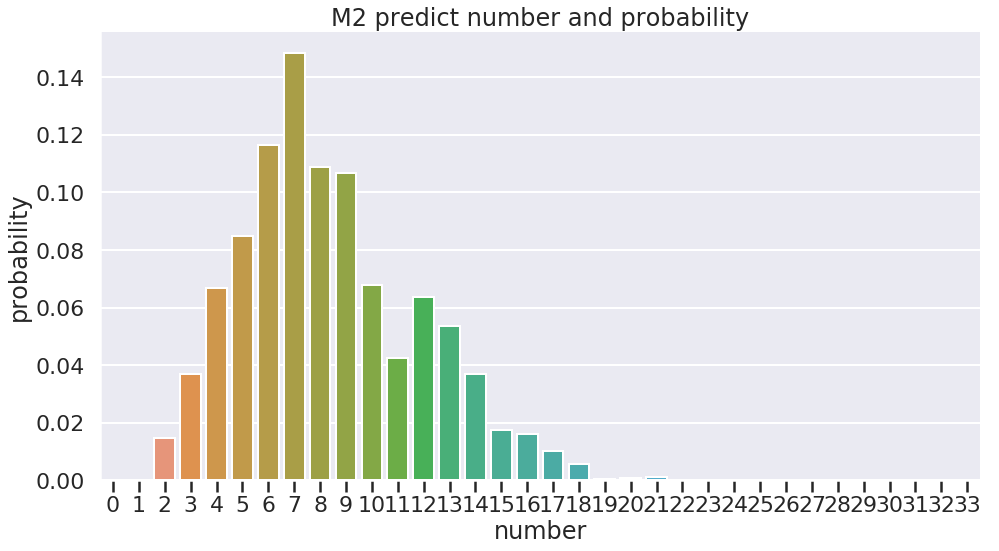

7 : 14.84%
6 : 11.64%
8 : 10.88%
9 : 10.69%
5 : 8.49%
10 : 6.78%
4 : 6.66%
12 : 6.35%
13 : 5.36%
11 : 4.23%
14 : 3.69%
3 : 3.69%
15 : 1.76%
16 : 1.62%
2 : 1.47%
17 : 1.03%
18 : 0.55%
21 : 0.10%
20 : 0.09%
19 : 0.04%
22 : 0.01%
23 : 0.00%
24 : 0.00%
25 : 0.00%
26 : 0.00%
28 : 0.00%
29 : 0.00%
31 : 0.00%
32 : 0.00%
0 : 0.00%
27 : 0.00%
30 : 0.00%
1 : 0.00%


M3_model.h5


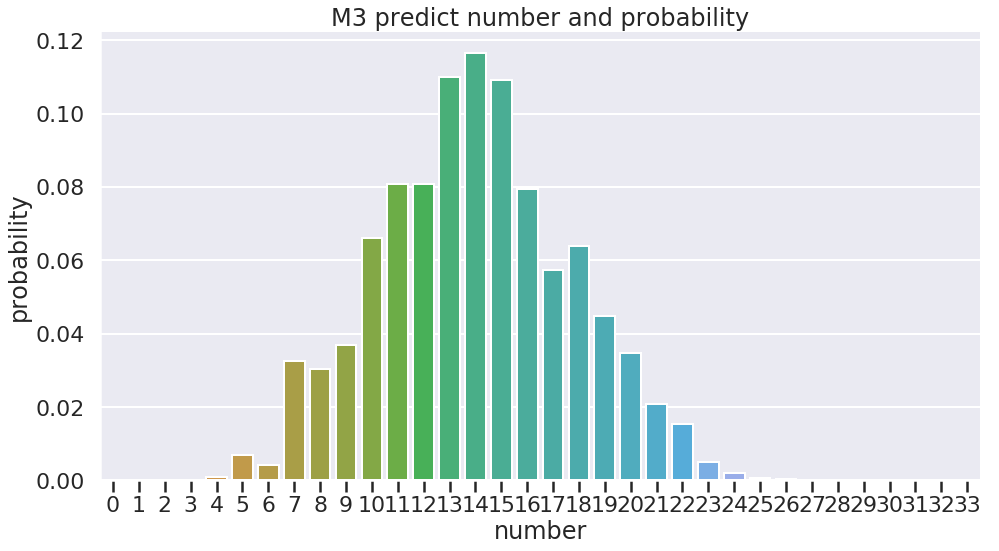

14 : 11.65%
13 : 11.01%
15 : 10.92%
11 : 8.07%
12 : 8.07%
16 : 7.95%
10 : 6.61%
18 : 6.40%
17 : 5.74%
19 : 4.47%
9 : 3.68%
20 : 3.48%
7 : 3.26%
8 : 3.04%
21 : 2.09%
22 : 1.54%
5 : 0.68%
23 : 0.51%
6 : 0.42%
24 : 0.19%
4 : 0.09%
25 : 0.07%
26 : 0.03%
27 : 0.01%
3 : 0.00%
28 : 0.00%
29 : 0.00%
0 : 0.00%
31 : 0.00%
2 : 0.00%
1 : 0.00%
32 : 0.00%
33 : 0.00%


M4_model.h5


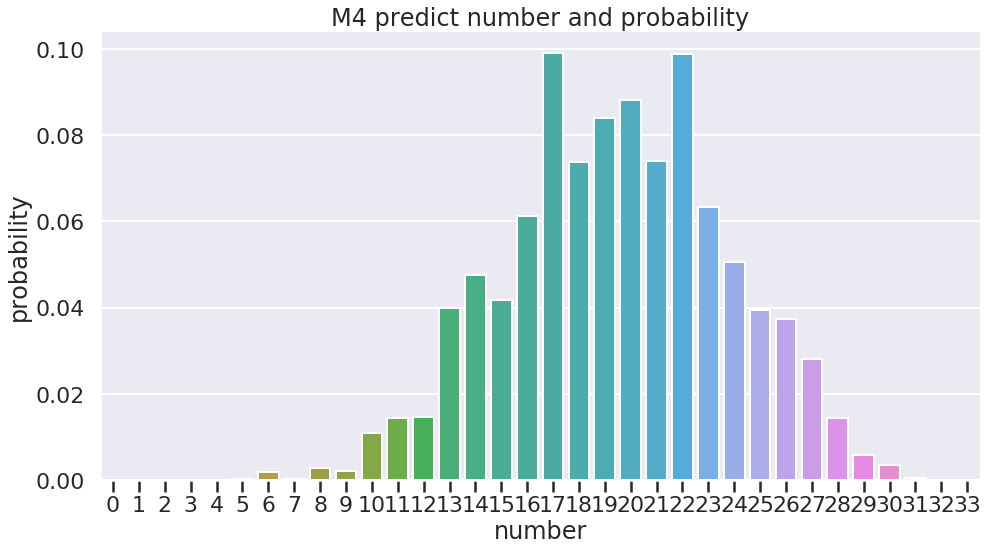

17 : 9.91%
22 : 9.87%
20 : 8.82%
19 : 8.39%
21 : 7.41%
18 : 7.37%
23 : 6.33%
16 : 6.12%
24 : 5.05%
14 : 4.76%
15 : 4.18%
13 : 4.01%
25 : 3.96%
26 : 3.74%
27 : 2.81%
12 : 1.48%
28 : 1.45%
11 : 1.44%
10 : 1.09%
29 : 0.60%
30 : 0.35%
8 : 0.28%
9 : 0.22%
6 : 0.20%
31 : 0.05%
7 : 0.04%
5 : 0.02%
33 : 0.01%
2 : 0.01%
0 : 0.01%
32 : 0.01%
3 : 0.01%
1 : 0.01%


M5_model.h5


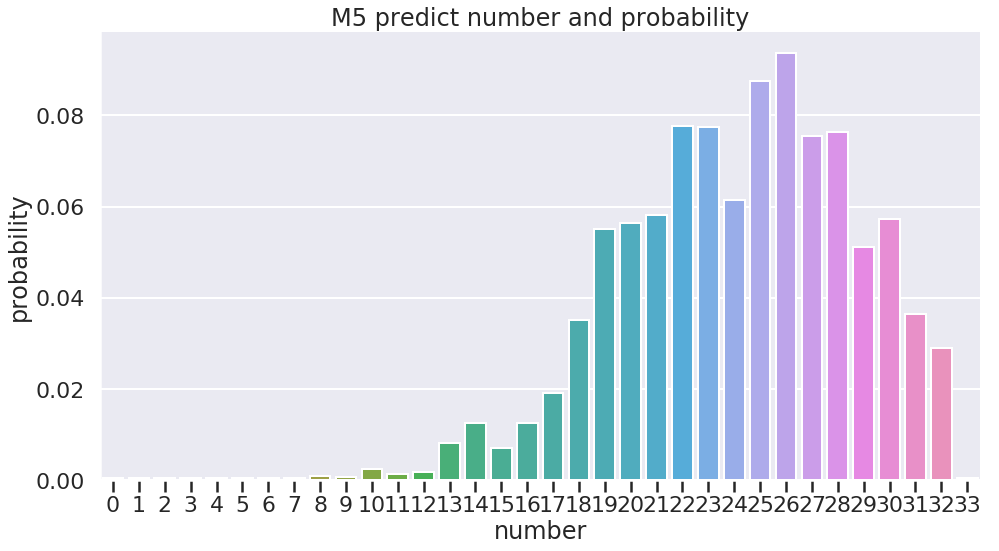

26 : 9.37%
25 : 8.74%
22 : 7.76%
23 : 7.75%
28 : 7.64%
27 : 7.54%
24 : 6.15%
21 : 5.82%
30 : 5.73%
20 : 5.64%
19 : 5.51%
29 : 5.11%
31 : 3.65%
18 : 3.51%
32 : 2.89%
17 : 1.90%
16 : 1.26%
14 : 1.26%
13 : 0.82%
15 : 0.72%
10 : 0.24%
12 : 0.19%
11 : 0.14%
8 : 0.10%
9 : 0.08%
2 : 0.06%
7 : 0.06%
3 : 0.05%
1 : 0.05%
0 : 0.05%
33 : 0.05%
5 : 0.05%
6 : 0.05%


M6_model.h5


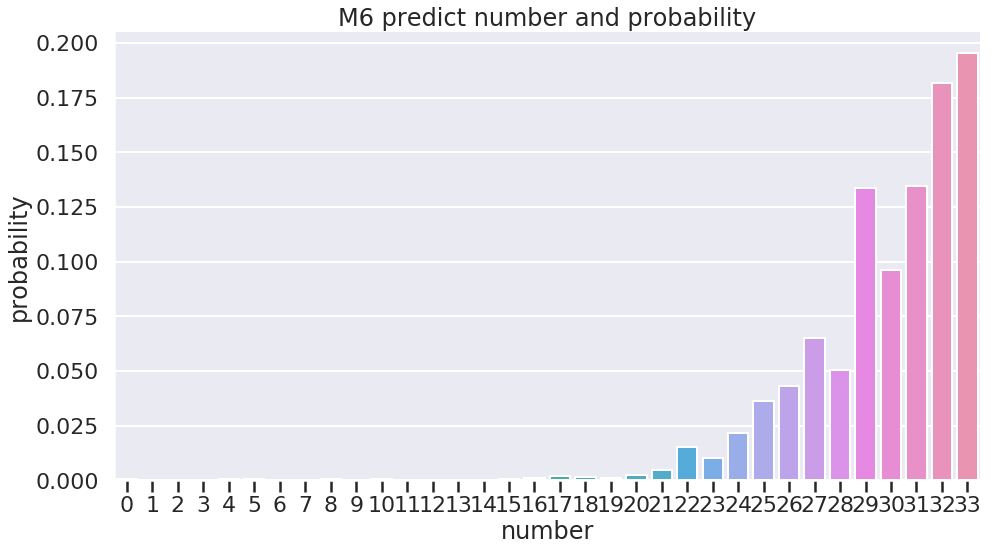

33 : 19.53%
32 : 18.14%
31 : 13.44%
29 : 13.35%
30 : 9.59%
27 : 6.50%
28 : 5.05%
26 : 4.31%
25 : 3.63%
24 : 2.15%
22 : 1.51%
23 : 1.04%
21 : 0.46%
20 : 0.23%
17 : 0.22%
18 : 0.14%
16 : 0.13%
19 : 0.09%
15 : 0.06%
5 : 0.04%
10 : 0.04%
0 : 0.04%
4 : 0.04%
8 : 0.04%
2 : 0.03%
1 : 0.03%
3 : 0.03%
6 : 0.03%
9 : 0.03%
7 : 0.03%
14 : 0.03%
13 : 0.02%
11 : 0.02%


M7_model.h5


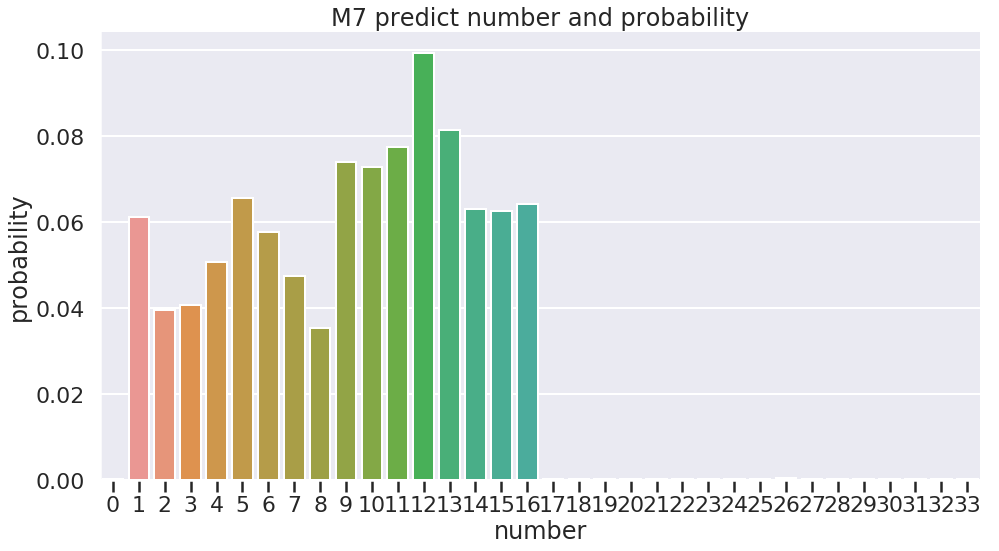

12 : 9.93%
13 : 8.15%
11 : 7.75%
9 : 7.41%
10 : 7.29%
5 : 6.55%
16 : 6.42%
14 : 6.31%
15 : 6.27%
1 : 6.11%
6 : 5.77%
4 : 5.07%
7 : 4.76%
3 : 4.07%
2 : 3.97%
8 : 3.54%
26 : 0.04%
20 : 0.04%
19 : 0.04%
23 : 0.04%
17 : 0.04%
28 : 0.04%
24 : 0.04%
29 : 0.04%
32 : 0.04%
18 : 0.03%
33 : 0.03%
0 : 0.03%
27 : 0.03%
31 : 0.03%
21 : 0.03%
22 : 0.03%
30 : 0.03%




In [0]:
from keras.models import load_model
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd
import requests
from bs4 import BeautifulSoup
import xlwt
import time
import seaborn as sns
import matplotlib.pyplot as plt

look_back=4

#获取第一页的内容
def get_one_page(url):
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
    }
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        return response.text
    return 

#解析第一页内容，数据结构化
def parse_one_page(html):

    soup = BeautifulSoup(html,'lxml')
    i = 0
    for item in soup.select('tr')[2:-1]:

        yield{
            'time':item.select('td')[i].text,
            'digit_1':item.select('td em')[0].text,
            'digit_2':item.select('td em')[1].text,
            'digit_3':item.select('td em')[2].text,
            'digit_4':item.select('td em')[3].text,
            'digit_5':item.select('td em')[4].text,
            'digit_6':item.select('td em')[5].text,
            'digit_7':item.select('td em')[6].text,
        }

def create_test_excel(look_back):
    f = xlwt.Workbook()                             
    sheet1 = f.add_sheet('ssq',cell_overwrite_ok=True)
    row0 = ["date","digit_1","digit_2","digit_3","digit_4","digit_5","digit_6","digit_7"]
    #写入第一行
    for j in range(0,len(row0)):
        sheet1.write(0,j,row0[j])

    #依次爬取每一页内容的每一期信息，并将其依次写入Excel
    i=0
    url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_1.html' 
    html = get_one_page(url)
        
        #写入每一期的信息
    for item in parse_one_page(html):
      
      sheet1.write(i+1,0,item['time'])
      sheet1.write(i+1,1,item['digit_1'])
      sheet1.write(i+1,2,item['digit_2'])
      sheet1.write(i+1,3,item['digit_3'])
      sheet1.write(i+1,4,item['digit_4'])
      sheet1.write(i+1,5,item['digit_5'])
      sheet1.write(i+1,6,item['digit_6'])
      sheet1.write(i+1,7,item['digit_7'])
      i+=1
            
      if i == look_back + 1:
        break
    
    f.save('ssq_test.xls')

create_test_excel(look_back)
data = pd.read_excel('ssq_test.xls')
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by = 'date')
data.reset_index(inplace=True)
del data['index']
del data['date']

D_1 = data['digit_1']
D_2 = data['digit_2']
D_3 = data['digit_3']
D_4 = data['digit_4']
D_5 = data['digit_5']
D_6 = data['digit_6']
D_7 = data['digit_7']

models = ['M1_model.h5', 'M2_model.h5', 'M3_model.h5', 'M4_model.h5', 'M5_model.h5','M6_model.h5','M7_model.h5']
tdatas = [D_1,D_2,D_3,D_4,D_5,D_6,D_7]


for (model,tdata) in zip(models,tdatas):
    
    print(model)
    M_ssq = load_model(model)

    test_X = to_categorical(np.asarray([tdata[-look_back:]]),num_classes=34)

    pred = M_ssq.predict(test_X)
    ranks = np.argsort(pred[0])
    
    
    dfp = pd.DataFrame(pred)
    dfplot = pd.DataFrame()
    dfplot['probability'] = dfp.T[0]
    dfplot['number'] = dfplot.index
    
    sns.set_context("poster")
    sns.set_style("darkgrid",{'xtick.bottom': True})
    sns.catplot(x='number',y='probability', kind="bar", height=8, aspect=1.8, data=dfplot)
    plt.title(model[:2] + ' predict number and probability')
    plt.ylabel('probability')
    plt.xlabel('number')
    plt.show()
    
    for i in range(1,34):
        print(str(ranks[-i]) + ' : %.2f%%' %(pred[0][ranks[-i]]*100))
    print('\n')

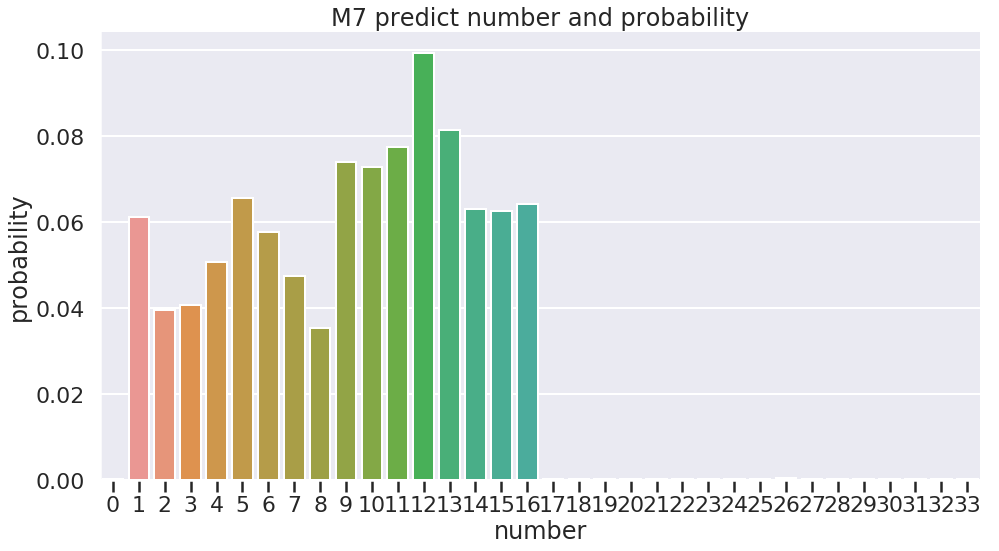

In [0]:
import matplotlib.pyplot as plt
sns.set_context("poster")
sns.set_style("darkgrid",{'xtick.bottom': True})
sns.catplot(x='number',y='probability', kind="bar", height=8, aspect=1.8, data=dfplot)
plt.title(model[:2] + ' predict number and probability')
plt.ylabel('probability')
plt.xlabel('number')
plt.show()